In [5]:
import numpy as np
from itertools import combinations
import progressbar
import itertools 
import networkx as nx
import pickle

# Create hashtag graph

First, define functions for creating a hashtag graph from a list of posts, input in the format of three lists: list of hashtags associated with each posts, list of succes scores for each post (at first, simply the number of likes it received), and a list of timestamps of the posts.

The graph will get pickled into a file defined by savename

In [71]:
def nodes_connected(graph, u, v):
     return u in graph.neighbors(v)
 
def make_graph(hashtag_list_of_lists,success_list,timestamp_list,savename='instagraph'):
    tag_graph = nx.Graph()
    for ind,hashtag_list in progressbar.progressbar(enumerate(hashtag_list_of_lists)):
        for hashtag in hashtag_list:
            if hashtag in tag_graph.nodes:
                success = tag_graph.nodes[hashtag]['success'] + success_list[ind]
                occurence = tag_graph.nodes[hashtag]['occurence'] + 1.0
                
                successes = list(tag_graph.nodes[hashtag]['successes'])
                successes.append(success_list[ind])
                successes = tuple(successes)
                
                timestamps = list(tag_graph.nodes[hashtag]['timestamps'])
                timestamps.append(timestamp_list[ind])
                timestamps = tuple(timestamps)
                
            else:
                success = success_list[ind]
                occurence = 1.0  
                successes = tuple([success_list[ind]])
                timestamps = tuple([timestamp_list[ind]])
            tag_graph.add_node(hashtag, success=success,occurence=occurence,
                              successes = successes, timestamps=timestamps)
        
        for a,b in itertools.combinations(hashtag_list,2):
            if nodes_connected(tag_graph,a,b):
                tag_graph[a][b]['weight']+=1
            else:
                tag_graph.add_edge(a,b,weight=1)
    with open(savename, 'wb') as f:
        pickle.dump(tag_graph,f)
    return tag_graph

Actually create the graph.

We scale the number of likes each post received by the number of followers the poster has, to control for the popularity of the poster in assigning hashtag popularity. For this, we load from the user dataset and extract the number of followers for each user.

We will first use the first 300,000 posts. We implement caching, so we don't have to create the same graph more than once

In [72]:
filepath = 'C:\\Users\\Swooty\\Documents\\Data science\\DataIncubator\\twitter\\insta_data\\media.csv'
df = pd.read_csv(filepath, sep=';', encoding='iso-8859-1')

filepath = 'C:\\Users\\Swooty\\Documents\\Data science\\DataIncubator\\twitter\\insta_data\\users.csv'
df2 = pd.read_csv(filepath, sep=';', encoding='iso-8859-1')

df_followers = df2.groupby(['sID']).count()

df_has_tags = df[pd.notnull(df['comments'])]
df_has_tags['tagset'] = df_has_tags['tagset'].apply(lambda x: x.split(','))

def get_followers(author_id):
    try:
        followers = df_followers['tID'][author_id]
    except(KeyError):
        followers = 1.0
    return followers
df_has_tags['followers'] = df_has_tags['id_author'].apply(get_followers)
df_has_tags['scaled_likes'] = df_has_tags['likes']/df_has_tags['followers']

df_has_tags = df_has_tags.sample(frac=1).reset_index(drop=True)

graph_lo = 0
graph_hi = 300000
hashtag_lil = df_has_tags['tagset'].tolist()[graph_lo:graph_hi]
likes_list = df_has_tags['scaled_likes'].tolist()[graph_lo:graph_hi]
timestamp_list = df_has_tags['TS_upload'].tolist()[graph_lo:graph_hi]
followers_list = df_has_tags['followers'].tolist()[graph_lo:graph_hi]

savename = 'instagraph_300K'

try:
    with open(savename, 'rb') as f:
        graph = pickle.load(f)
except(FileNotFoundError):
    graph = make_graph(hashtag_lil,likes_list,timestamp_list,savename=savename)    

C:\Users\Swooty\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Swooty\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Swooty\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

Let's see what a node of the graph looks like:

In [73]:
graph.nodes['costarica']

{'success': 556.8152470152597,
 'occurence': 88.0,
 'successes': (0.9402985074626866,
  5.0,
  30.0,
  0.2857142857142857,
  0.3582089552238806,
  3.3047619047619046,
  15.0,
  0.47761194029850745,
  144.175,
  3.8333333333333335,
  4.819047619047619,
  1.0298507462686568,
  1.0294117647058822,
  8.0,
  4.333333333333333,
  0.3880597014925373,
  0.7058823529411765,
  0.40298507462686567,
  0.4626865671641791,
  3.75,
  4.627272727272727,
  0.8333333333333334,
  0.7941176470588235,
  0.29850746268656714,
  0.13432835820895522,
  0.5588235294117647,
  0.5522388059701493,
  3.1666666666666665,
  0.14705882352941177,
  0.3880597014925373,
  0.5074626865671642,
  0.2835820895522388,
  0.40310077519379844,
  3.6952380952380954,
  0.47761194029850745,
  0.47761194029850745,
  4.0,
  0.6865671641791045,
  0.5970149253731343,
  3.876190476190476,
  0.373134328358209,
  3.3333333333333335,
  3.1666666666666665,
  3.9909090909090907,
  7.0,
  0.6865671641791045,
  3.7904761904761903,
  0.47761194

# Look at a small piece of the graph

Here, we will pick a hashtag and then make a small sub-graph that contains that hashtag and the most popular/common hashtags connected to it on the graph. 

In [74]:
scaled_success_list = []

for node in graph.nodes:
    ss = graph.nodes[node]['success']/graph.nodes[node]['occurence']
    occ = graph.nodes[node]['occurence']
    scaled_success_list.append((node,ss,occ))
best_tag = sorted(scaled_success_list, key = lambda x: -x[1])[0][0]
common_tag = sorted(scaled_success_list, key = lambda x: -x[2])[35][0]


In [75]:
def make_sub_graph(center_tag,occurence_cutoff = 0, success_cutoff = 0):
    sub_graph = nx.Graph()
    sub_graph.add_node(center_tag, 
                       success = graph.nodes[center_tag]['success'],
                       occurence = graph.nodes[center_tag]['occurence'],
                       ss = graph.nodes[center_tag]['success']/graph.nodes[center_tag]['occurence'])
    
    for tag in graph.neighbors(center_tag):
        if graph.nodes[tag]['occurence']>occurence_cutoff:
            if graph.nodes[tag]['success']/graph.nodes[tag]['occurence']>success_cutoff:
                sub_graph.add_node(tag,
                           success = graph.nodes[tag]['success'],
                           occurence = graph.nodes[tag]['occurence'],
                           ss = graph.nodes[tag]['success']/graph.nodes[tag]['occurence'])

    for a,b in itertools.combinations(sub_graph.nodes,2):
        if nodes_connected(graph,a,b):
            sub_graph.add_edge(a,b,weight = graph[a][b]['weight'])
        
    return sub_graph

In [76]:
def get_sub_graph_sizes(sub_graph):
    node_size_list = []
    occurence_list = []
    for node in sub_graph.nodes:
        node_size_list.append(sub_graph.nodes[node]['ss'])
        occurence_list.append(sub_graph.nodes[node]['occurence'])
        
    edge_width_list = []
    for a,b in sub_graph.edges:
        occ_a = sub_graph.nodes[a]['occurence']
        occ_b = sub_graph.nodes[b]['occurence']
        edge_width_list.append(float(sub_graph[a][b]['weight'])/float(occ_a)/float(occ_b))
        
    return node_size_list, occurence_list, edge_width_list

In [77]:
sub_graph = make_sub_graph('costarica',occurence_cutoff=30, success_cutoff=200)
node_size_list, occurence_list, edge_width_list = get_sub_graph_sizes(sub_graph)
len(node_size_list)

4

C:\Users\Swooty\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


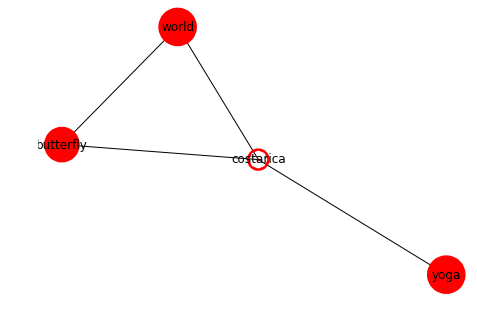

In [78]:
import matplotlib.pyplot as  plt
nx.drawing.nx_pylab.draw(sub_graph, 
                         linewidths = 20,
                         node_size = node_size_list, 
                       #  width = 10*edge_width_list,
                         edge_color = 'k',
                         with_labels=True)
plt.savefig('sample_graph.png', dpi=300, bbox_inches='tight')

# Validate that hashtag popularity is predictive of post popularity

First, for all the posts, we get a hashtag success score by looking adding success rating (from the graph) of each of the hashtags included in the post.

In [79]:
def get_hashtag_success(hashtag_list):
    summ = 0.0
    num = 0.0
    for ind, node in enumerate(hashtag_list):
        try:
            summ += float(graph.nodes[node]['success'])/float(graph.nodes[node]['occurence'])
            num += 1.0
        except(KeyError):
            pass
    if num == 0.0:
        return float('NaN')
    return summ
df_has_tags['hashtag_success'] = df_has_tags['tagset'].apply(get_hashtag_success)

Pick a subset of the data (not the subset used in making the graph!) and use linear regression to extract a correlation between the hashtag success score of the post and the actual success, given by (# of likes)/(# of followers), of the post.

In [81]:
from sklearn.linear_model import LinearRegression

fit_lo = graph_hi
fit_hi = graph_hi + 100000

y = df_has_tags[pd.notnull(df_has_tags['hashtag_success'])]['scaled_likes'][fit_lo:fit_hi]
X =df_has_tags[pd.notnull(df_has_tags['hashtag_success'])][['hashtag_success']][fit_lo:fit_hi]

lr = LinearRegression()
lr.fit(X,y)
print('Score = {score}'.format(score = lr.score(X,y)))
print('Coef = {coef}, intersept = {ic}'.format(coef = lr.coef_, ic = lr.intercept_))

Score = 0.10255503107083064
Coef = [0.09731288], intersept = 8.437812357033918


Use a separate set of data (call it the test set) to score the validity of the linear fit

In [82]:
test_lo = fit_hi
test_hi = fit_hi +100000
y_test = df_has_tags[pd.notnull(df_has_tags['hashtag_success'])]['scaled_likes'][test_lo:test_hi]
X_test = df_has_tags[pd.notnull(df_has_tags['hashtag_success'])][['hashtag_success']][test_lo:test_hi]
test_sc = lr.score(X_test,y_test)
print('Score on test set = {score}'.format(score = test_sc))

Score on test set = 0.094432026239333


And make a plot of both the data used for the fit, the test data, and the linear fit

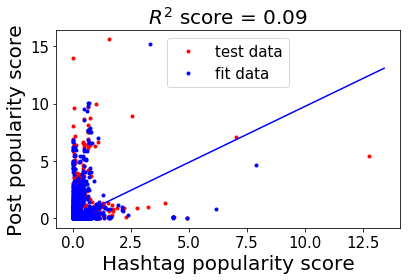

In [85]:
from matplotlib import rcParams
rcParams['axes.labelsize'] = 20
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 15

rcParams['pdf.fonttype'] = 42 # True type fonts
rcParams['font.family'] = 'sans-serif'

fig = plt.figure()
pan = fig.add_subplot(111)
pan.plot(X_test/10000,y_test/1000, 'r.',label = 'test data')
pan.plot(X/10000,y/1000, 'b.', label = 'fit data')
start,stop = pan.get_xlim()
xlist = np.linspace(start*1000,stop*10000, 1000)
ylist = lr.intercept_ + lr.coef_[0]*xlist
pan.plot(xlist/10000,ylist/1000,'b-')
pan.set_xlabel('Hashtag popularity score')
pan.set_ylabel('Post popularity score')
pan.set_title(r'$R^2$ score = {:.2f}'.format(test_sc), size = 20)
plt.legend()
plt.tight_layout()
fig.show()
plt.savefig('validation.png',dpi=500)

# Explore time series of particular hashtags

In [86]:
occurence_list = []
for node in graph.nodes:
    occ = graph.nodes[node]['occurence']
    occurence_list.append((node,occ))
occurence_list = sorted(occurence_list, key = lambda x: -x[1])
occurence_list[:10]

[('instagood', 43974.0),
 ('photooftheday', 35610.0),
 ('vscocam', 27454.0),
 ('instagramhub', 24340.0),
 ('iphoneonly', 23895.0),
 ('instamood', 22906.0),
 ('jj', 22496.0),
 ('iphonesia', 21251.0),
 ('igers', 20089.0),
 ('picoftheday', 18952.0)]

16x9fordays
743
743
2013-03-01 11:31:46


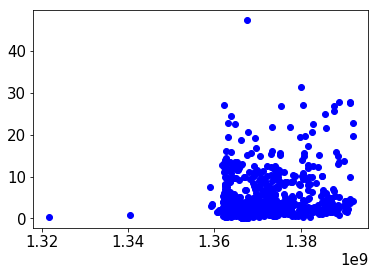

In [93]:
from datetime import datetime

ind = 400
print(occurence_list[ind][0])
successes = list(graph.nodes[occurence_list[ind][0]]['successes'])
timestamps = list(graph.nodes[occurence_list[ind][0]]['timestamps'])
datetimelist = []
for timestamp in timestamps:
    datetimelist.append(datetime.fromtimestamp(timestamp))
print(len(datetimelist))
print(len(successes))
print(datetimelist[-1])
figure = plt.figure()
panel = figure.add_subplot(111)
panel.plot(timestamps,successes,'bo')